# Linear separable models

## So far
+ We've covered two ways to do prediction with a single variable, classification using logistic regression and prediction using a line and least squares.
+ What if we have several predictiors? 
+ In both the logistic and linear regression models, we had a linear predictor, specifically, 

$$
\eta_i = \beta_0 + \beta_1 x_i.
$$

+ In the continuous case, we were modeling the expected value of the outcomes as linear. 
+ In the binary case, we were assuming that the naturual logarithm of the odds of a 1 outcome was linear. 

## Estimation

+ Minimize loss function for $\beta_0$ and $\beta_1$
+ Linear regression case

$$
\sum_{i=1}^n || y_i - \eta_i||^2 
$$

+ Logistic regression case

$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^{\eta_i}} \right\} \right].
$$

## Extending these models

$$
\eta_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \ldots \beta_{p-1} x_{p-1,i}
$$

+ If we think about this as vectors and matrices, we obtain

$$
\eta = X \beta
$$

+ where $\eta$ is an $n \times 1$ vector, 
+ $X$ is an $n \times p$ matrix with $i,j$ entry $x_{ij}$
+ $\beta$ is a $p\times 1$ vector with entries $\beta_j$. 

# Example 

Consider our voxel level data

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm
## this sets some style parameters  
sns.set()
## Read in the data 
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

Proton density (PD) is the outcome, 

Let's first try to fit the proton density data from the other imaging data. 

In [28]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]

In [29]:
results = smf.ols('PD ~ FLAIR + T1 + T2  + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', 
                  data = trainingDat).fit()
# print(results.summary2())

```
# Truncated results
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2099      0.130      1.610      0.112      -0.050       0.470
FLAIR         -0.0041      0.078     -0.053      0.958      -0.159       0.151
T1            -0.2987      0.089     -3.348      0.001      -0.477      -0.121
T2             0.5436      0.086      6.313      0.000       0.372       0.715
FLAIR_10      -0.0743      0.325     -0.228      0.820      -0.723       0.575
T1_10          0.2940      0.160      1.835      0.071      -0.026       0.614
T2_10          0.0066      0.310      0.021      0.983      -0.611       0.624
FLAIR_20       1.7173      0.696      2.466      0.016       0.328       3.106
==============================================================================
```

## Logistic regression example

In [30]:
x = dat[['FLAIR','T1', 'T2', 'FLAIR_10', 'T1_10', 'T2_10', 'FLAIR_20']]
y = dat[['GOLD_Lesions']]
## Add the intercept column
x = sm.tools.add_constant(x)
xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

In [31]:
fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()

Optimization terminated successfully.
         Current function value: 0.284652
         Iterations 8


In [32]:
#fit.summary()()

```
            coef	std err	       z	P>|z|	 [0.025	0.975]
const	 -3.3909	1.767	  -1.919	0.055	 -6.854	  0.072
FLAIR	  1.5931	1.147	   1.389	0.165	 -0.655	  3.841
T1	      2.4984	1.086	   2.301	0.021	  0.371	  4.626
T2	      1.3153	0.994	   1.323	0.186	 -0.633	  3.263
FLAIR_10  8.6555	3.678	   2.353	0.019	  1.446	 15.865
T1_10	  1.6271	1.850	   0.879	0.379	 -1.999	  5.253
T2_10 	 -5.7317	3.572	  -1.605	0.109	-12.732	  1.269
FLAIR_20 -20.1731	8.786	  -2.296	0.022	-37.392	 -2.954
```

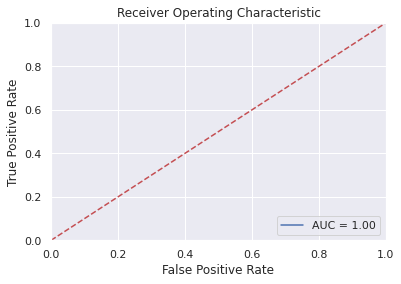

In [33]:
phatTesting = fit.predict(xtesting)

## See here for plotting
## https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, threshold = skl.metrics.roc_curve(ytesting, phatTesting)
roc_auc = skl.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Aside different python packages

So far we've explored several plotting libraries including: default pandas methods, matplotlib, seaborn and plotly. We've also looked at several fitting libraries including to some extent numpy, but especially scikitlearn and statsmodels. What's the difference? Well, these packages are all mantained by different people and have different features and goals. For example, scikitlearn is more expansive than statsmodels, but statsmodels functions more like one is used to with statistical output. Matplotlib is very expansive, but seaborn has nicer default options and is a little easier. So, when doing data science with python, one has to get used to trying out a few packages, weighing the cost and benefits of each, and picking one. 

'statsmodels', what we're using above, has multiple methods for fitting binary models including: `sm.Logit`, `smf.logit`, `BinaryModel` and `glm`. Here I'm just going to use `Logit` which does not use the formula syntax of `logit`. Note, by default, this does not add an intercept this way. So, I'm adding a column of ones, which adds an intercept.

Consider the following which uses the formula API


In [34]:
results = smf.logit(formula = 'GOLD_Lesions ~ FLAIR + T1 + T2 + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', data = trainingDat).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.284652
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                   76
Model:                          Logit   Df Residuals:                       68
Method:                           MLE   Df Model:                            7
Date:                Tue, 10 Oct 2023   Pseudo R-squ.:                  0.5893
Time:                        09:26:27   Log-Likelihood:                -21.634
converged:                       True   LL-Null:                       -52.679
Covariance Type:            nonrobust   LLR p-value:                 5.764e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6411      1.885     -2.462      0.014      -8.336      -0.946
FLAIR          2.2939      1.132      2.026      0.043       0.075       4.513
T1             2.2414      0.968      2.314      0.021       0.343       4.140
T2             1.7219      0.962      1.789      0.074      -0.164       3.608
FLAIR_10       7.8263      3.907      2.003      0.045       0.170      15.483
T1_10          1.8550      1.605      1.156      0.248      -1.291       5.001
T2_10         -3.9036      2.964     -1.317      0.188      -9.713       1.906
FLAIR_20     -18.9455      7.940     -2.386      0.017     -34.507      -3.384
==============================================================================
"""